# Comparsion Of Denoising Algorithms
---

Step 1: Import the required library for image processing

In [1]:
from skimage import data, img_as_float, measure
from skimage.restoration import denoise_bilateral, denoise_tv_chambolle, denoise_wavelet, estimate_sigma
from skimage.util import random_noise
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio

import imutils
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd

Step 2: Define functions

In [2]:
def add_noise(img, mode):
    noise_img = random_noise(img, mode=mode)
    noise_img = np.array(255*noise_img, dtype = 'uint8')
    return noise_img

def add_sp_noise(img):
    return add_noise(img, "s&p")

def add_shot_noise(img):
    return add_noise(img, "poisson")

def get_measurement(original, to_compare):
#     mse = measure.compare_mse(original, to_compare)
    #psnr = measure.compare_psnr(noisy, to_compare)
    psnr = peak_signal_noise_ratio(original, to_compare)
    (ssim_score, diff) = ssim(original, to_compare, multichannel=True, full=True)
    return round(psnr, 2), round(ssim_score, 2)

def denoise_img(noise_img, mode):
    start_time = time.time()
    if mode == 'TV':
        noise_img = img_as_float(noise_img, False)
        denoised_img = denoise_tv_chambolle(noise_img, weight=0.1, multichannel=True)
    elif mode == 'BI':
        noise_img = img_as_float(noise_img, False)
        denoised_img = denoise_bilateral(noise_img, sigma_color=0.05, sigma_spatial=15, multichannel=True)
    elif mode == 'WA':
        noise_img = img_as_float(noise_img, False)
        denoised_img = denoise_wavelet(noise_img, multichannel=True, rescale_sigma=True)
    elif mode == 'WB':
        noise_img = img_as_float(noise_img, False)
        denoised_img = denoise_wavelet(noise_img, multichannel=True, method='BayesShrink', mode='soft', rescale_sigma=True)
    elif mode == 'WV':
        noise_img = img_as_float(noise_img, False)
        sigma_est = estimate_sigma(noise_img, multichannel=True, average_sigmas=True)
        denoised_img = denoise_wavelet(noise_img, multichannel=True, method='VisuShrink', mode='soft', sigma=sigma_est, rescale_sigma=True)
    elif mode == 'ME':
        denoised_img = cv2.medianBlur(noise_img,9)
    elif mode == 'NO':
        denoised_img = cv2.fastNlMeansDenoisingColored(noise_img,None,10,10,7,21)
    else:
        denoised_img = [0]
    runtime = round(time.time() - start_time, 2)
    return denoised_img, runtime

def showEnhancementIndex(filter_name, noisy_psnr, noisy_ssim, new_psnr, new_ssim, duration):
    psnr_enhancement = (new_psnr - noisy_psnr) / noisy_psnr
    ssim_enhancement = (new_ssim - noisy_ssim) / noisy_ssim
    enhancement_index = ssim_enhancement + psnr_enhancement
    time_efficiency = enhancement_index / duration
    # print(filter_name + ' PSNR enhancement = {:.2%}'.format(psnr_enhancement))
    # print(filter_name + ' SSIM enhancement = {:.2%}'.format(ssim_enhancement))
    # print(filter_name + ' Enhancement index = {:.2%}'.format(ssim_enhancement + psnr_enhancement))
    return '{:.2%}'.format(psnr_enhancement), '{:.2%}'.format(ssim_enhancement), '{:.2%}'.format(enhancement_index), '{:.2%}'.format(time_efficiency)

# Analysing Scikit Image Data With Artificial Noise

In [31]:
img = data.chelsea()
sp_noise_img = add_sp_noise(img)
shot_noise_img = add_shot_noise(img)

float_img = img_as_float(img, False)
float_sp_noise = img_as_float(sp_noise_img, False)
float_shot_noise = img_as_float(shot_noise_img, False)

Text(0.5, 0, 'PSNR: 27.47, SSIM: 0.65')

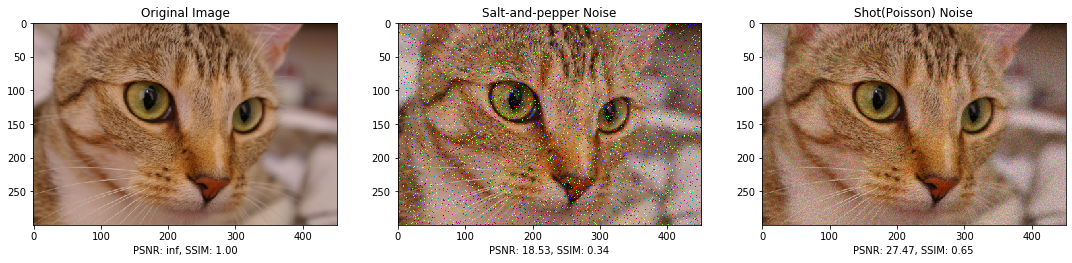

In [32]:
label = 'PSNR: {:.2f}, SSIM: {:.2f}'
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)

a = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(img)
a.set_title('Original Image')
psnr, ssim_score = get_measurement(img, img)
a.set_xlabel(label.format(psnr, ssim_score))

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(sp_noise_img)
a.set_title('Salt-and-pepper Noise')
sp_psnr, sp_ssim_score = get_measurement(img, sp_noise_img)
a.set_xlabel(label.format(sp_psnr, sp_ssim_score))

a = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(shot_noise_img)
a.set_title('Shot(Poisson) Noise')
shot_psnr, shot_ssim_score = get_measurement(img, shot_noise_img)
a.set_xlabel(label.format(shot_psnr, shot_ssim_score))

In [34]:
noise_measure = [[sp_psnr, sp_ssim_score, shot_psnr, shot_ssim_score]]
pd.DataFrame(noise_measure, columns=['SP PSNR', 'SP SSIM', 'Shot PSNR', 'Shot SSIM'])

,SP PSNR,SP SSIM,Shot PSNR,Shot SSIM
0,18.53,0.34,27.47,0.65


In [33]:
fig.savefig('chelsea.png')
cv2.imwrite('chelsea_sp.jpg', cv2.cvtColor(sp_noise_img,  cv2.COLOR_RGB2BGR))
cv2.imwrite('chelsea_shot.jpg',cv2.cvtColor(shot_noise_img,  cv2.COLOR_RGB2BGR))

True

## Run Denoising Alogorithms

In [40]:
noisy = shot_noise_img

In [41]:
tv_chambolle, tv_chambolle_runtime = denoise_img(noisy, 'TV')
bilateral, bilateral_runtime = denoise_img(noisy, 'BI')
median, median_runtime = denoise_img(noisy, 'ME')
non_local_means, non_local_means_median_runtime = denoise_img(noisy, 'NO')
wavelet, wavelet_runtime = denoise_img(noisy, 'WA')
wavelet_bayes, wavelet_bayes_runtime = denoise_img(noisy, 'WB')
wavelet_visu, wavelet_visu_runtime = denoise_img(noisy, 'WV')

Text(0.5, 0, 'PSNR: 26.61, SSIM: 0.79')

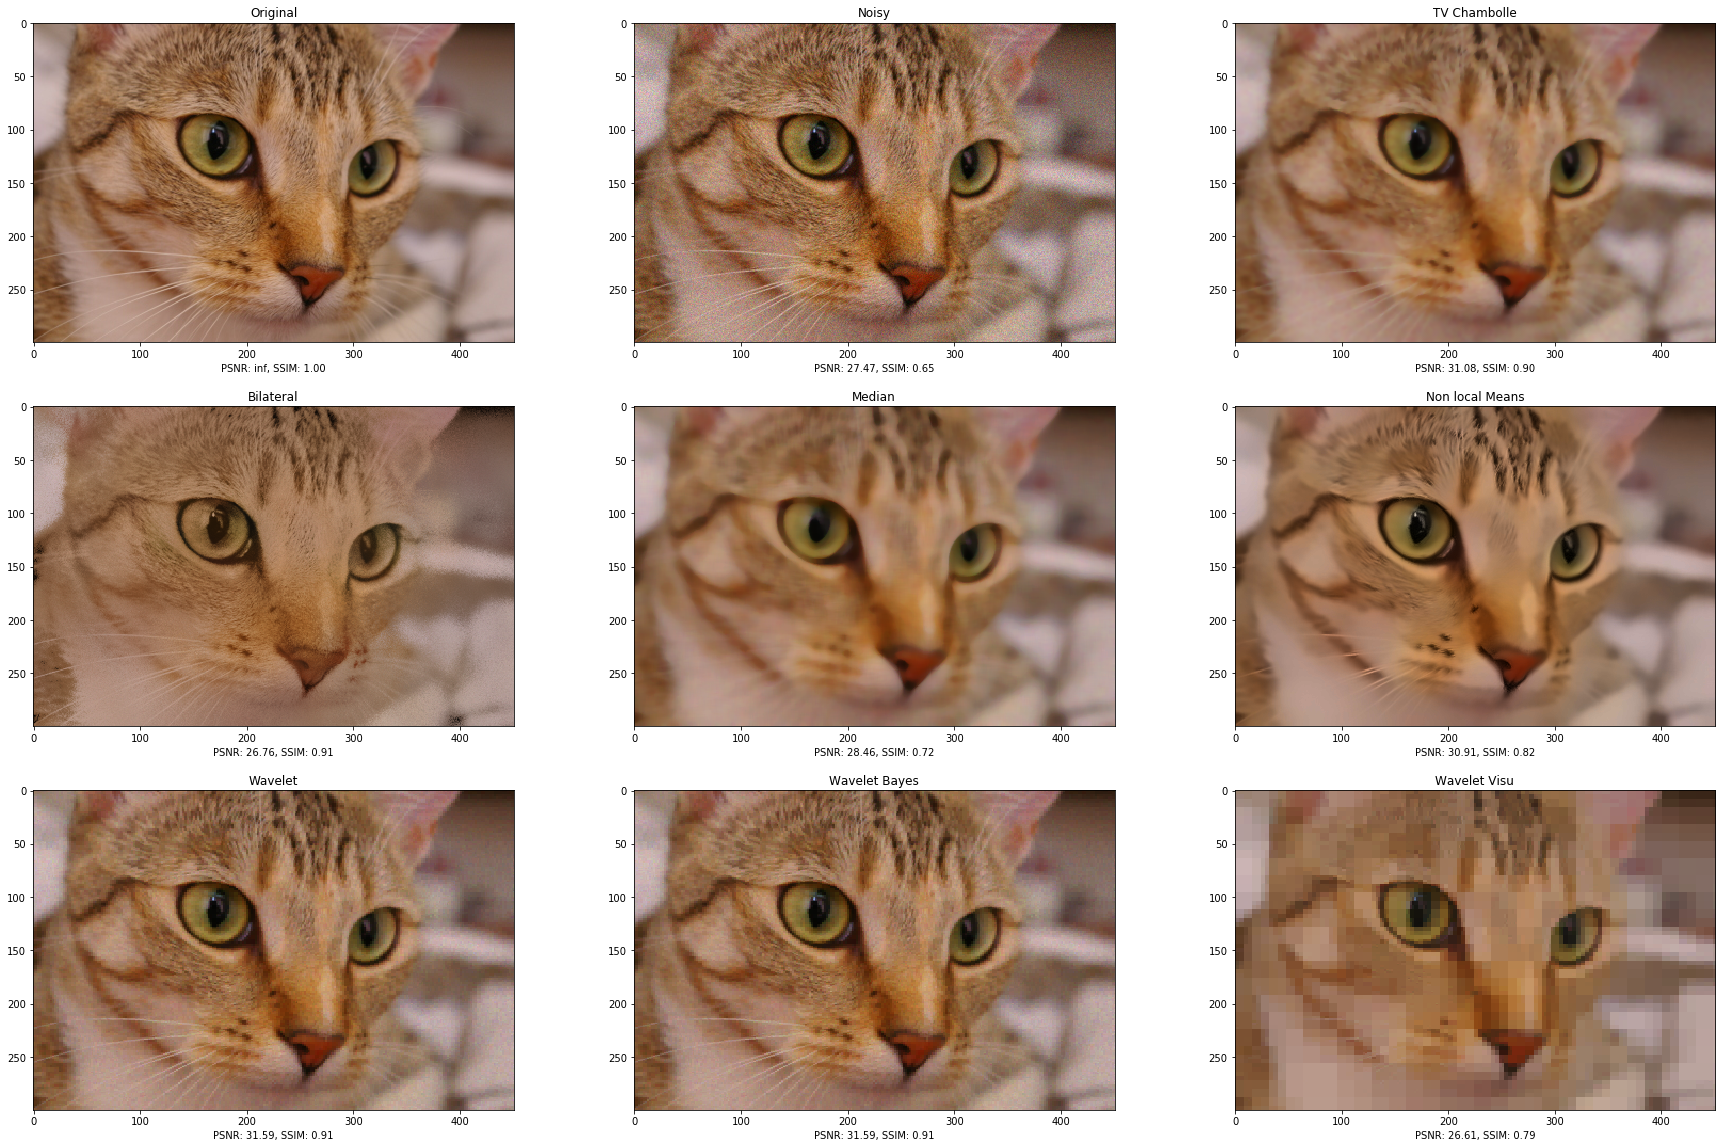

In [42]:
label = 'PSNR: {:.2f}, SSIM: {:.2f}'
fig_result, axs = plt.subplots(3, 3)
fig_result.set_size_inches(30.5, 20, forward=True)

axs[0, 0].imshow(img)
axs[0, 0].set_title('Original')
psnr, ssim_score = get_measurement(img, img)
axs[0, 0].set_xlabel(label.format(psnr, ssim_score))

axs[0, 1].imshow(noisy)
axs[0, 1].set_title('Noisy')
noisy_psnr, noisy_ssim_score = get_measurement(img, noisy)
axs[0, 1].set_xlabel(label.format(noisy_psnr, noisy_ssim_score))

axs[0, 2].imshow(tv_chambolle)
axs[0, 2].set_title('TV Chambolle')
tv_psnr, tv_ssim_score = get_measurement(float_img, img_as_float(tv_chambolle, False))
tv_psnr_enhance, tv_ssim_score_enhance, tv_enhance_index, tv_time_efficiency = showEnhancementIndex('TV', noisy_psnr, noisy_ssim_score, tv_psnr, tv_ssim_score, tv_chambolle_runtime)
axs[0, 2].set_xlabel(label.format(tv_psnr, tv_ssim_score))

axs[1, 0].imshow(bilateral)
axs[1, 0].set_title('Bilateral')
bi_psnr, bi_ssim_score = get_measurement(float_img, img_as_float(bilateral, False))
bi_psnr_enhance, bi_ssim_score_enhance, bi_enhance_index, bi_time_efficiency = showEnhancementIndex('Bilateral', noisy_psnr, noisy_ssim_score, bi_psnr, bi_ssim_score, bilateral_runtime)
axs[1, 0].set_xlabel(label.format(bi_psnr, bi_ssim_score))

axs[1, 1].imshow(median)
axs[1, 1].set_title('Median')
me_psnr, me_ssim_score = get_measurement(img, median)
me_psnr_enhance, me_ssim_score_enhance, me_enhance_index, me_time_efficiency= showEnhancementIndex('Median', noisy_psnr, noisy_ssim_score, me_psnr, me_ssim_score, median_runtime)
axs[1, 1].set_xlabel(label.format(me_psnr, me_ssim_score))

axs[1, 2].imshow(non_local_means)
axs[1, 2].set_title('Non local Means')
no_psnr, no_ssim_score = get_measurement(img, non_local_means)
no_psnr_enhance, no_ssim_score_enhance, no_enhance_index, no_time_efficiency = showEnhancementIndex('Non local Means', noisy_psnr, noisy_ssim_score, no_psnr, no_ssim_score, non_local_means_median_runtime)
axs[1, 2].set_xlabel(label.format(no_psnr, no_ssim_score))

axs[2, 0].imshow((wavelet * 255).astype(np.uint8))
axs[2, 0].set_title('Wavelet')
wa_psnr, wa_ssim_score = get_measurement(float_img, img_as_float(wavelet, False))
wa_psnr_enhance, wa_ssim_score_enhance, wa_enhance_index, wa_time_efficiency = showEnhancementIndex('Wavelet', noisy_psnr, noisy_ssim_score, wa_psnr, wa_ssim_score, wavelet_runtime)
axs[2, 0].set_xlabel(label.format(wa_psnr, wa_ssim_score))

axs[2, 1].imshow((wavelet_bayes * 255).astype(np.uint8))
axs[2, 1].set_title('Wavelet Bayes')
wb_psnr, wb_ssim_score = get_measurement(float_img, img_as_float(wavelet_bayes, False))
wb_psnr_enhance, wb_ssim_score_enhance, wb_enhance_index, wb_time_efficiency = showEnhancementIndex('Wavelet Bayes', noisy_psnr, noisy_ssim_score, wb_psnr, wb_ssim_score, wavelet_bayes_runtime)
axs[2, 1].set_xlabel(label.format(wb_psnr, wb_ssim_score))

axs[2, 2].imshow((wavelet_visu * 255).astype(np.uint8))
axs[2, 2].set_title('Wavelet Visu')
wv_psnr, wv_ssim_score = get_measurement(float_img, img_as_float(wavelet_visu, False))
wv_psnr_enhance, wv_ssim_score_enhance, wv_enhance_index, wv_time_efficiency = showEnhancementIndex('Wavelet Visu', noisy_psnr, noisy_ssim_score, wv_psnr, wv_ssim_score, wavelet_visu_runtime)
axs[2, 2].set_xlabel(label.format(wv_psnr, wv_ssim_score))

## Analysis Result

In [43]:
result = [['TV', tv_psnr, tv_ssim_score, tv_chambolle_runtime, tv_psnr_enhance, tv_ssim_score_enhance, tv_enhance_index, tv_time_efficiency],
        ['BI', bi_psnr, bi_ssim_score, bilateral_runtime, bi_psnr_enhance, bi_ssim_score_enhance, bi_enhance_index, bi_time_efficiency], 
        ['ME', me_psnr, me_ssim_score, median_runtime, me_psnr_enhance, me_ssim_score_enhance, me_enhance_index, me_time_efficiency], 
        ['NO', no_psnr, no_ssim_score, non_local_means_median_runtime, no_psnr_enhance, no_ssim_score_enhance, no_enhance_index, no_time_efficiency], 
        ['WA', wa_psnr, wa_ssim_score, wavelet_runtime, wa_psnr_enhance, wa_ssim_score_enhance, wa_enhance_index, wa_time_efficiency], 
        ['WB', wb_psnr, wb_ssim_score, wavelet_bayes_runtime, wb_psnr_enhance, wb_ssim_score_enhance, wb_enhance_index, wb_time_efficiency], 
        ['WV', wv_psnr, wv_ssim_score, wavelet_visu_runtime, wv_psnr_enhance, wv_ssim_score_enhance, wv_enhance_index, wv_time_efficiency]
       ]
pd.DataFrame(result, columns=['Filter', 'PSNR', 'SSIM', 'Denoising Duration', 'PSNR Enhancement', 'SSIM Enhancement', 'Enhancement index', 'Time Efficiency'])

,Filter,PSNR,SSIM,Denoising Duration,PSNR Enhancement,SSIM Enhancement,Enhancement index,Time Efficiency
0,TV,31.08,0.90,0.18,13.14%,38.46%,51.60%,286.68%
1,BI,26.76,0.91,22.76,-2.58%,40.00%,37.42%,1.64%
2,ME,28.46,0.72,0.01,3.60%,10.77%,14.37%,1437.32%
3,NO,30.91,0.82,0.69,12.52%,26.15%,38.68%,56.05%
4,WA,31.59,0.91,0.02,15.00%,40.00%,55.00%,2749.91%
5,WB,31.59,0.91,0.02,15.00%,40.00%,55.00%,2749.91%
6,WV,26.61,0.79,0.03,-3.13%,21.54%,18.41%,613.59%


## Save The Figure

In [44]:
fig_result.savefig('chelsea_shot_denoised_result.png')